In [14]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import re
import time

from collections import Counter
#sns.set()
sns.set(style="white", color_codes=True)
%matplotlib inline

# LNA

In [15]:
# import data for seasonal rankings
rankings_path = 'Data/Team/Rankings/regular/lna/*'
df_rankings = []

for file in glob.iglob(rankings_path):
    frame = pd.read_csv(file,sep=';')
    frame['Season'] = file[31:35]
    df_rankings.append(frame)
df_rankings = pd.concat(df_rankings)
df_rankings.head(15)

,﻿R,Team,GP,W,OTW,SOW,SOL,OTL,L,GF,GA,GDF,PTS,Season
0,1,SC Bern,50,30,4,0,2,3,11,187,136,51,103,0809
1,2,ZSC Lions,50,26,3,5,0,3,13,176,149,27,97,0809
2,3,Kloten Flyers,50,27,3,3,2,1,14,174,130,44,96,0809
3,4,HC Davos,50,25,3,3,3,2,14,184,135,49,92,0809
4,5,HC Lugano,50,19,4,4,5,2,16,175,156,19,80,0809
5,6,Genève-Servette HC,50,22,5,0,2,0,21,157,140,17,78,0809
6,7,Fribourg-Gottéron,50,19,3,4,1,3,20,154,143,11,75,0809
7,8,EV Zug,50,20,1,2,2,3,22,171,166,5,71,0809
8,9,SCL Tigers,50,19,2,3,1,1,24,170,180,-10,69,0809
9,10,SC Rapperswil-Jona Lakers,50,14,0,1,2,3,30,143,208,-65,49,0809


In [16]:
# helper to sort plots by median rank/pts
temp = df_rankings.groupby('Team').agg({'\ufeffR': 'median', 'PTS': 'median'})
t1 = temp.sort_values(by='\ufeffR',inplace=False)
t2 = temp.sort_values(by='PTS',ascending=False)

In [17]:
df_rankings_grouped = df_rankings.groupby(by=['Team', 'Season'], as_index=True).agg({'\ufeffR': 'first', 'PTS': 'first'})
df_features = df_rankings.groupby(by=['Team', 'Season'], as_index=True).agg({'\ufeffR': 'first'})
df_rankings.drop(['GP','W','OTW','SOW','SOL','OTL','L','GF','GA','GDF','PTS','Season'],axis=1,inplace=True)

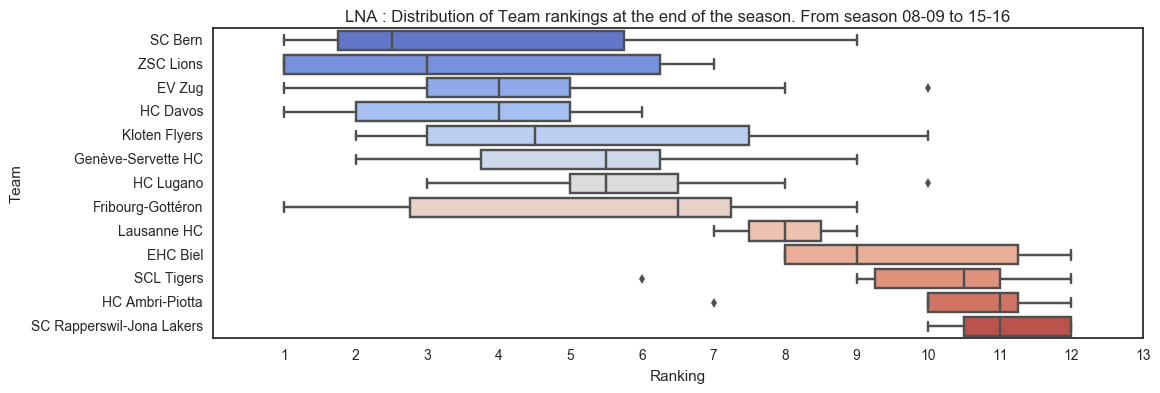

In [18]:
# plot
plt.figure(figsize=(12,4))
ax = sns.boxplot(x='\ufeffR', y='Team',data=df_rankings_grouped.reset_index(), orient="h", palette='coolwarm', order=t1.index)
ax.set_xlabel('Ranking')
ax.set_xticks(np.arange(1,14))
ax.set_title('LNA : Distribution of Team rankings at the end of the season. From season 08-09 to 15-16');

plt.savefig('Plots/lna_rank_distrib.png')

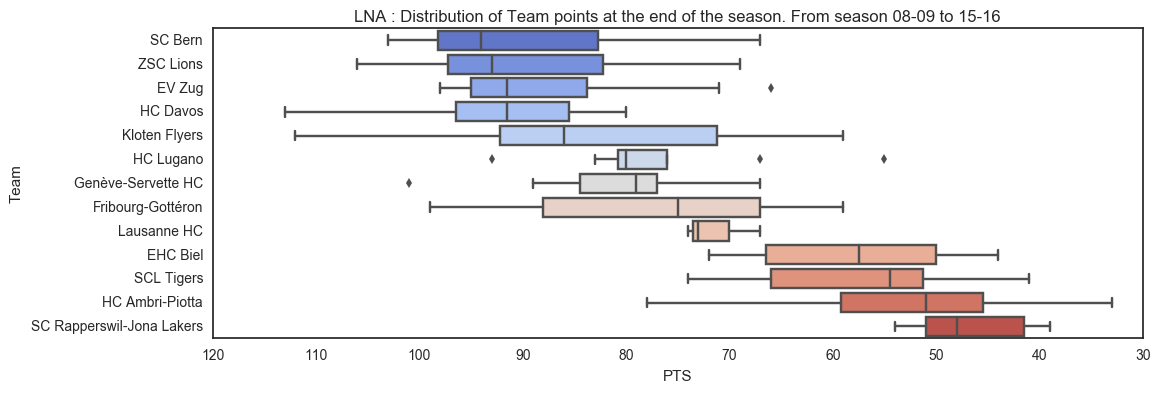

In [19]:
plt.figure(figsize=(12,4))
ax = sns.boxplot(x='PTS', y='Team',data=df_rankings_grouped.reset_index(), orient="h", palette='coolwarm', order=t2.index)
ax.set_xlabel('PTS')
ax.invert_xaxis()
#ax.set_xticks(np.arange(1,14))
ax.set_title('LNA : Distribution of Team points at the end of the season. From season 08-09 to 15-16');

plt.savefig('Plots/lna_points_distrib.png')

In [20]:
playoff_ranks = [5,5,2,1,5,5,3,3,
                1,2,3,5,3,5,5,5,
                1,2,3,3,5,5,5,5,
                3,5,3,5,2,5,1,5,
                2,1,3,3,5,5,5,5,
                1,3,2,3,5,5,5,5,
                2,3,5,5,1,3,5,5,
                5,3,3,5,2,5,5,1]
df_rankings = df_rankings[df_rankings['\ufeffR'] <= 8]
df_rankings['playoff'] = playoff_ranks
df_rankings.rename(columns={'playoff' : 'rank_PO', '\ufeffR' : 'rank_RE'},inplace=True)
df_rankings['number'] = 20
df_rankings_agg = df_rankings.groupby(['rank_RE', 'rank_PO']).agg({'number' : 'sum'}).reset_index()

In [21]:
df_rankings_agg['total'] = df_rankings_agg.apply(lambda x: x.loc['rank_RE']*x.loc['number'], axis=1)
df_rankings_mean = df_rankings_agg.groupby(['rank_PO']).agg({'total' : 'sum', 'number' : 'sum'})
df_rankings_mean['mean'] = df_rankings_mean['total']/df_rankings_mean['number']
df_rankings_mean

,number,total,mean
rank_PO,,,
1,160,580,3.62500
2,160,440,2.75000
3,320,1200,3.75000
5,640,3540,5.53125


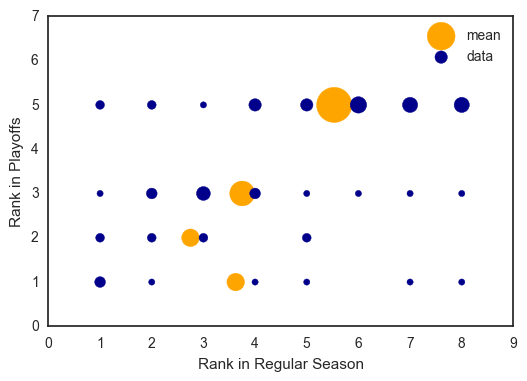

In [22]:
plt.scatter(x=df_rankings_mean['mean'],y=df_rankings_mean.reset_index()['rank_PO'],
            s=df_rankings_mean['number'], color='orange', label='mean')
plt.scatter(x=df_rankings_agg['rank_RE'],y=df_rankings_agg['rank_PO'],
            s=df_rankings_agg['number'], color='darkblue', label='data')
plt.xlabel('Rank in Regular Season')
plt.ylabel('Rank in Playoffs')
plt.ylim([0,7])
plt.legend();

plt.savefig('Plots/lna_PO_vs_RE.png')

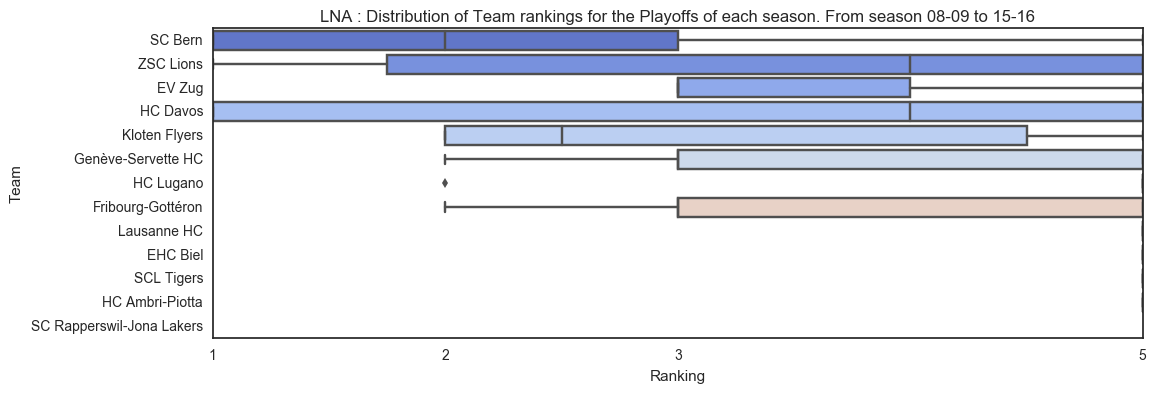

In [23]:
# plot
plt.figure(figsize=(12,4))
ax = sns.boxplot(x='rank_PO', y='Team',data=df_rankings, orient="h", palette='coolwarm', order=t1.index)
ax.set_xlabel('Ranking')
ax.set_xticks([1,2,3,5])
ax.set_title('LNA : Distribution of Team rankings for the Playoffs of each season. From season 08-09 to 15-16');

plt.savefig('Plots/lna_playoff_distrib.png')

# LNB

In [24]:
# import data for seasonal rankings
rankings_path = 'Data/Team/Rankings/regular/lnb/*'
df_rankings = []

for file in glob.iglob(rankings_path):
    frame = pd.read_csv(file,sep=';')
    frame['Season'] = file[31:35]
    df_rankings.append(frame)
df_rankings = pd.concat(df_rankings)
df_rankings.head(15)

,﻿R,Team,GP,W,OTW,SOW,SOL,OTL,L,GF,GA,GDF,PTS,Season
0,1,EHC Visp,45,27,3,3,1,1,10,224,140,84,95,0910
1,2,EHC Olten,45,30,0,1,2,0,12,187,129,58,94,0910
2,3,Lausanne HC,45,28,1,1,2,1,12,166,121,45,91,0910
3,4,HC Sierre,45,21,2,3,4,3,12,161,132,29,80,0910
4,5,HC Ajoie,45,21,3,2,1,1,17,157,149,8,75,0910
5,6,HC La Chaux-de-Fonds,45,20,2,0,4,0,19,177,166,11,68,0910
6,7,SC Langenthal,45,16,0,3,0,0,26,124,156,-32,54,0910
7,8,EHC Basel Sharks,45,12,0,1,2,2,28,111,180,-69,42,0910
8,9,Hockey Thurgau,45,12,0,1,1,3,28,131,189,-58,42,0910
9,10,GCK Lions,45,10,0,2,0,0,33,123,199,-76,34,0910


In [25]:
# helper to sort plots by median rank/pts
temp = df_rankings.groupby('Team').agg({'\ufeffR': 'median', 'PTS': 'median'})
t1 = temp.sort_values(by='\ufeffR',inplace=False)
t2 = temp.sort_values(by='PTS',ascending=False)

In [26]:
df_rankings_grouped = df_rankings.groupby(by=['Team', 'Season'], as_index=True).agg({'\ufeffR': 'first', 'PTS': 'first'})
df_features = df_rankings.groupby(by=['Team', 'Season'], as_index=True).agg({'\ufeffR': 'first'})
df_rankings.drop(['GP','W','OTW','SOW','SOL','OTL','L','GF','GA','GDF','PTS','Season'],axis=1,inplace=True)

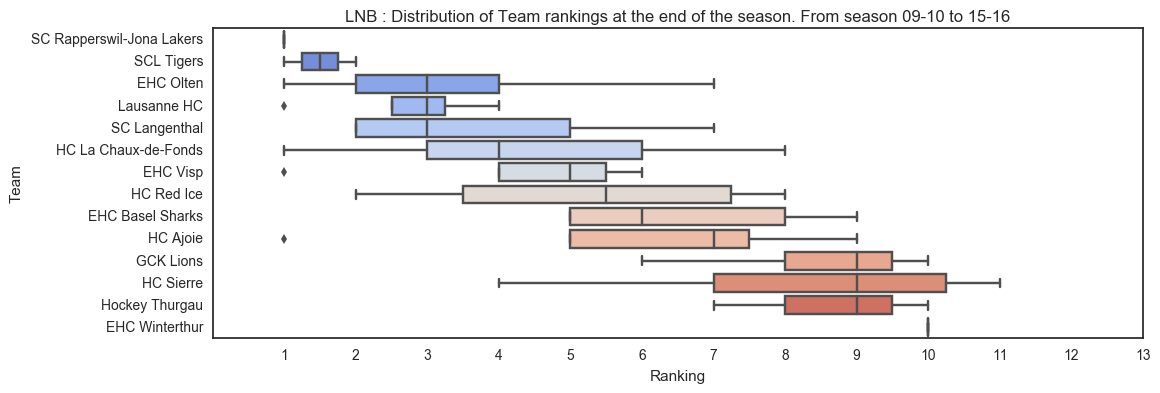

In [27]:
# plot
plt.figure(figsize=(12,4))
ax = sns.boxplot(x='\ufeffR', y='Team',data=df_rankings_grouped.reset_index(), orient="h", palette='coolwarm', order=t1.index)
ax.set_xlabel('Ranking')
ax.set_xticks(np.arange(1,14))
ax.set_title('LNB : Distribution of Team rankings at the end of the season. From season 09-10 to 15-16');

plt.savefig('Plots/lnb_rank_distrib.png')

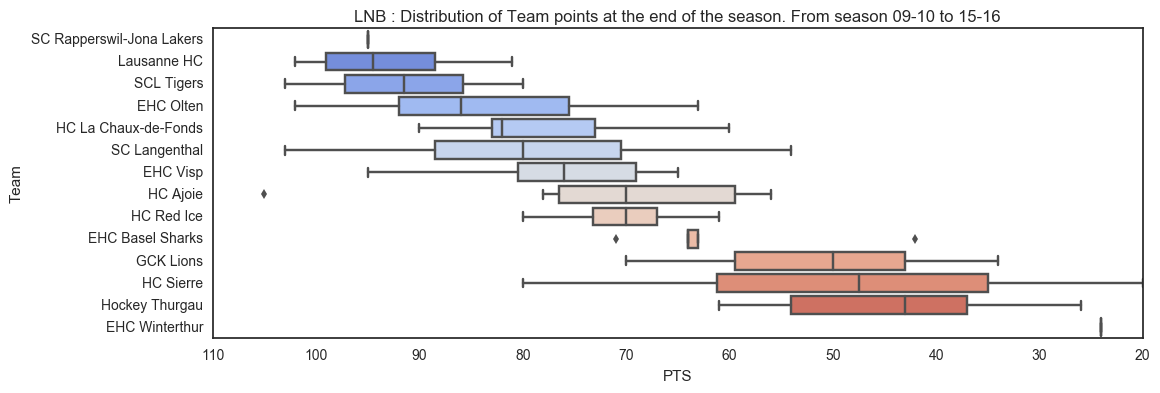

In [28]:
plt.figure(figsize=(12,4))
ax = sns.boxplot(x='PTS', y='Team',data=df_rankings_grouped.reset_index(), orient="h", palette='coolwarm', order=t2.index)
ax.set_xlabel('PTS')
ax.invert_xaxis()
#ax.set_xticks(np.arange(1,14))
ax.set_title('LNB : Distribution of Team points at the end of the season. From season 09-10 to 15-16');

plt.savefig('Plots/lnb_points_distrib.png')

# Features

In [29]:
df_features.reset_index(inplace=True)
df_features[['Season']] = df_features[['Season']].apply(pd.to_numeric)
df_features = df_features.drop(df_features[df_features.Season == 809].index)
df_features.rename(index=str, columns={'\ufeffR' : 'R'}, inplace=True)
df_features.set_index(['Team','Season'],inplace=True)
df_features.head(10)

R
Team             Season   
EHC Basel Sharks 910     8
                 1011    5
                 1112    5
                 1213    9
                 1314    6
EHC Olten        910     2
                 1011    2
                 1112    7
                 1213    3
                 1314    1

In [36]:
df_stats = pd.read_csv('Data/Cleaned_Data/team_regular_season.csv')
df_stats.rename(index=str, columns={'Year' : 'Season'}, inplace=True)
df_stats.set_index(['Team','Season'], inplace=True)
df_stats.drop(['Number of year'],axis=1,inplace=True)
df_stats.head(10)

GF  PK SI  PK SI/GP  PK GA  PK GA/GP    PK%    PKT  \
Team             Season                                                        
EHC Basel Sharks 910     111    224      4.98     53      1.18  76.34  19961   
                 1011    138    211      4.69     38      0.84  81.99  19849   
                 1112    132    212      4.71     45      1.00  78.77  18770   
                 1213    138    232      4.64     46      0.92  80.17  21341   
                 1314    144    209      4.64     41      0.91  80.38  19490   
EHC Biel         809     126    306      6.12     55      1.10  82.03  27694   
                 910     134    266      5.32     45      0.90  83.08  24336   
                 1011    135    201      4.02     47      0.94  76.62  19409   
                 1112    114    200      4.00     35      0.70  82.50  19787   
                 1213    160    198      3.96     33      0.66  83.33  19053   

                         PK time/GP  SHG  PK GF/GP     ...      5'  10'  GM  \
Team             Season                                ...                    
EHC Basel Sharks 910            443    2      0.04     ...       0   12   0   
                 1011           441    6      0.13     ...       3    2   2   
                 1112           417    9      0.20     ...       1    4   0   
                 1213           426    8      0.16     ...       2   10   1   
                 1314           433    8      0.18     ...       3   12   2   
EHC Biel         809            553    3      0.06     ...       2    8   4   
                 910            486    7      0.14     ...       2   12   1   
                 1011           388    3      0.06     ...       4    8   4   
                 1112           395    1      0.02     ...       6    2   5   
                 1213           381    7      0.14     ...       1    8   1   

                         MP  PIM Total  PP OP  PP OP/GP    PP%    PPT  \
Team             Season                                                 
EHC Basel Sharks 910      0        642    198      4.40  16.67  18182   
                 1011     2        597    197      4.38  16.75  18728   
                 1112     1        517    183      4.07  14.75  16934   
                 1213     1        662    189      3.78  18.52  18475   
                 1314     1        667    185      4.11  21.62  17106   
EHC Biel         809      0        812    261      5.22  11.11  25912   
                 910      1        776    259      5.18  16.99  23920   
                 1011     0        632    201      4.02  19.40  19384   
                 1112     1        602    198      3.96  15.15  19433   
                 1213     0        583    231      4.62  16.02  21809   

                         PP time/GP  
Team             Season              
EHC Basel Sharks 910            404  
                 1011           416  
                 1112           376  
                 1213           369  
                 1314           380  
EHC Biel         809            518  
                 910            478  
                 1011           387  
                 1112           388  
                 1213           436  

[10 rows x 34 columns]

In [31]:
df_feat_viz = pd.concat([df_features,df_stats],axis=1)
df_feat_viz.head(10)

R   GF  PK SI  PK SI/GP  PK GA  PK GA/GP    PK%  \
Team             Season                                                      
EHC Basel Sharks 910     8.0  111    224      4.98     53      1.18  76.34   
                 1011    5.0  138    211      4.69     38      0.84  81.99   
                 1112    5.0  132    212      4.71     45      1.00  78.77   
                 1213    9.0  138    232      4.64     46      0.92  80.17   
                 1314    6.0  144    209      4.64     41      0.91  80.38   
EHC Biel         809     NaN  126    306      6.12     55      1.10  82.03   
                 910     NaN  134    266      5.32     45      0.90  83.08   
                 1011    NaN  135    201      4.02     47      0.94  76.62   
                 1112    NaN  114    200      4.00     35      0.70  82.50   
                 1213    NaN  160    198      3.96     33      0.66  83.33   

                           PKT  PK time/GP  SHG     ...      5'  10'  GM  MP  \
Team             Season                             ...                        
EHC Basel Sharks 910     19961         443    2     ...       0   12   0   0   
                 1011    19849         441    6     ...       3    2   2   2   
                 1112    18770         417    9     ...       1    4   0   1   
                 1213    21341         426    8     ...       2   10   1   1   
                 1314    19490         433    8     ...       3   12   2   1   
EHC Biel         809     27694         553    3     ...       2    8   4   0   
                 910     24336         486    7     ...       2   12   1   1   
                 1011    19409         388    3     ...       4    8   4   0   
                 1112    19787         395    1     ...       6    2   5   1   
                 1213    19053         381    7     ...       1    8   1   0   

                         PIM Total  PP OP  PP OP/GP    PP%    PPT  PP time/GP  
Team             Season                                                        
EHC Basel Sharks 910           642    198      4.40  16.67  18182         404  
                 1011          597    197      4.38  16.75  18728         416  
                 1112          517    183      4.07  14.75  16934         376  
                 1213          662    189      3.78  18.52  18475         369  
                 1314          667    185      4.11  21.62  17106         380  
EHC Biel         809           812    261      5.22  11.11  25912         518  
                 910           776    259      5.18  16.99  23920         478  
                 1011          632    201      4.02  19.40  19384         387  
                 1112          602    198      3.96  15.15  19433         388  
                 1213          583    231      4.62  16.02  21809         436  

[10 rows x 35 columns]

In [32]:
df_feat_viz.columns

Index(['R', 'GF', 'PK SI', 'PK SI/GP', 'PK GA', 'PK GA/GP', 'PK%', 'PKT',
       'PK time/GP', 'SHG', 'PK GF/GP', 'GF/GP', 'GA', 'GA/GP', 'GF even',
       'GF even/GP', 'GA even', 'GA even/GP', 'PPG', 'PPG/GP', 'PP GA',
       'PP GA/GP', 'SOWGF', 'SOWGA', '2' ', '5'', '10'', 'GM', 'MP',
       'PIM Total', 'PP OP', 'PP OP/GP', 'PP%', 'PPT', 'PP time/GP'],
      dtype='object')

In [35]:
init_time = time.time()
i = 1
for (x,y) in itertools.combinations(df_feat_viz.columns, r=2):
    fig = plt.figure(figsize=(8,8))
    ax = sns.jointplot(x=df_feat_viz[x], y=df_feat_viz[y], kind='reg')
#    ax.set_xlabel(x)
#    ax.set_ylabel(y)
    plt.savefig(r'Plots/features/{}_vs_{}'.format(re.sub('[\s/]', '_', x),re.sub('[\s/]', '_', y)))
    plt.close(ax.fig)
    if i % 10 == 0 : print(np.round((time.time() - init_time)*10)/10, i)
    i += 1

/Users/fredericmoret/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


10.6 10


/Users/fredericmoret/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


19.9 20
33.4 30
41.8 40
51.7 50
61.6 60
71.0 70
80.6 80
91.3 90
101.6 100
110.9 110
118.5 120
128.1 130
138.0 140
147.0 150
156.8 160
165.8 170
173.6 180
181.8 190
193.4 200
205.0 210
216.4 220
230.8 230
242.0 240
250.2 250
258.2 260
269.7 270
278.7 280
289.9 290
298.2 300
306.9 310
314.8 320
322.4 330
336.3 340
350.9 350
358.6 360
366.6 370
374.1 380
381.8 390
389.3 400
397.0 410
408.8 420
416.8 430
424.3 440
432.0 450
439.8 460
448.5 470
457.0 480
464.5 490
472.3 500
484.8 510
492.5 520
500.0 530
507.7 540
515.2 550
522.9 560
530.8 570
538.6 580
546.3 590
